## Robust Production - Inventory

The production inventory problem is one that addresses uncertainty in inventory management scenarios. The objective is to minimize the costs associated with inventory management while ensuring that customer demand is met consistently over a planning horizon. Since the demand is uncertain and varies within a specific bound, this problem can be classified as a robust optimization problem.

Takingn the example introduced in Ben-Tal et al. (2004), let us consider a single product inventory system which is comprised of a warehouse and $I$ factories. The planning horizon is $T$ periods. At period $t$:
- $d_t$ is the demand of the product that is uncertain
- $v(t)$ is the amount of product in the warehouse at the beginning of a period
- $p_i(t)$ is the amount of product to be produced during period $t$ by factory $i$ and is used to satisfy the demand of the period
- $P_i(t)$ is the maximal production capacity of factory $i$ in time period $t$
- $c_i(t)$ is the cost of producing a unit of product at factory $i$ in time period $t$
- $Q_i(t)$ is the maximal cumulative production capacity of factory $i$ in time period $t$
- $V_{min}$ and $V_{max}$ are the minimal and maximal storage capacity of the warehouse, respectively

With this information, the robust counterpart to the problem can be modeled into the following linear program:

$$
\begin{aligned}
& \text{minimize} \quad  F \\
& \text{subject to} \\
& \vec{c(t)}^T\vec{p(t)} \leq F,\\
& 0 \leq p_i(t) \leq P_i(t),\\
& 1^T\vec{p(t)} \leq Q_i,\\
& V_{min} \leq v(1) + 1^T\vec{p} - 1^T\vec{d} \leq V_{max}\\

\end{aligned}
$$


We first import the required packages and generate the data. 

In [65]:
import numpy as np 
import cvxpy as cp 
import lropt
import warnings
import matplotlib.pyplot as plt
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings('ignore', category=UserWarning, module='cvxpy')
warnings.filterwarnings('ignore', category=SparseEfficiencyWarning)

Next, we can consider $I$ = 3 factories producing a product in one warehouse. The time horizon $T$ is 24 periods. The  maximal production capacity of each one of the factories at each two-weeks period is $P_i(t) = 567$, and the integral production capacity of each one of the factories for a year is $Q = 13600$. The inventory at the warehouse should not be less then $500$ units, and cannot exceed $2000$ units. Initially, the inventory sits at $500$ units.

In [66]:
np.random.seed(1)
T = 24 #number of periods
I = 3 #number of factories
V_MIN = 300 # The lower and upper bounds must be relaxed for larger uncertainty, or the problem becomes infeasible
V_MAX = 10000
HALF = 0.5
SEASONAL_MULTIPLIER = 1000
INTEGRAL_CAPACITY = 13600
RHO = 1
V_INITIAL = 500
MAX_CAPACITY = 567
PROPORTION_1 = 0.4
PROPORTION_2 = 0.4
P = np.full((I, T), MAX_CAPACITY)
Q = [INTEGRAL_CAPACITY]*I

F = cp.Variable(nonneg = True)
p = cp.Variable((I,T), nonneg = True)


The production cost for a factory $i$ at a period $t$ is given by:
$$
\begin{align*}
c_i(t) =  \alpha_i \left(1 - \frac{1}{2} \sin \left(\frac{\pi (t-1)}{12}\right)\right), \quad t  \in [1, 2, ... ,24] \\
\alpha_i \in [1, 1.5, 2]
\end{align*}
$$

In [67]:
c = [] 
alphas = np.array([1, 1.5, 2])

for t in range (1, T+1):
    c.append((alphas * (1 + HALF*np.sin(np.pi*(t-1)/(T*HALF)))).flatten())
c = np.array(c).T


In the robust optimization context, the demand is considered uncertain and seasonal, reaching its peak in winter. Specifically, the demand follows a seasonal pattern represented by:
$$
\begin{align*}
d^*(t) =  1000\left(1 - \frac{1}{2} \sin \left(\frac{\pi (t-1)}{12}\right)\right), \quad  t  \in [1, 2, ... ,24] \\
\end{align*}
$$


To handle this uncertainty, we adopt the norm uncertainty set. This uncertainty set is defined by:
$$
 \mathcal{U}_{\text{Norm}} = \{Az+b \ | \ z\| \|_p \le \rho\}
$$
This set allows us to define bounds for the uncertainty set to indicate that the demand is within an uncertainty level of $20\%$.

In [68]:
t_values = np.arange(1, T + 1)
d_star = SEASONAL_MULTIPLIER * (1 + HALF * np.sin(np.pi * (t_values - 1) / (T * HALF)))

# Construct lhs
eye_matrix = np.eye(T)
neg_eye_matrix = -np.eye(T)
lhs = np.concatenate((eye_matrix, neg_eye_matrix), axis=0)

# Construct rhs
rhs_upper1 = (1 + PROPORTION_1) * d_star
rhs_lower1 = (-1 + PROPORTION_1) * d_star
rhs1 = np.hstack((rhs_upper1, rhs_lower1))

rhs_upper2 = (1 + PROPORTION_2) * d_star
rhs_lower2 = (-1 + PROPORTION_1) * d_star
rhs2 = np.hstack((rhs_upper2, rhs_lower2))

d1 = lropt.UncertainParameter(T, uncertainty_set=lropt.Polyhedral(lhs=lhs, rhs=rhs1)) #uncertain demand
d2= lropt.UncertainParameter(T, uncertainty_set=lropt.Polyhedral(lhs=lhs, rhs=rhs2)) #uncertain demand

Next, we will define all the constraints of the problem in a list.

In [69]:
constraints = [
    cp.sum(cp.multiply(c, p)) <= F,
    p <= P,
    cp.sum(p,1) <= Q,
]

for i in range(1,T+1):
    multvec = np.hstack([np.ones(i),np.zeros(T-i)])
    constraints += [cp.sum(cp.sum(p,0)[:i]) - multvec@d1 + V_INITIAL >= V_MIN]
    constraints += [cp.sum(cp.sum(p,0)[:i]) - multvec@d1 + V_INITIAL <= V_MAX]

objective = cp.Minimize(F)
prob = lropt.RobustProblem(objective, constraints)
prob.solve()
sol = F.value
print(f"The robust optimal value is {sol}")
print(np.round(p.value))

The robust optimal value is None


TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable rint method

Finally, we can define the objective and solve the problem. 

In [ ]:
objective = cp.Minimize(F)
prob = lropt.RobustProblem(objective, constraints)
prob.solve()
sol = F.value
print(f"The robust optimal value is {sol}")
print(np.round(p.value))

The robust optimal value is 43670.82346867439
[[567. 567. 567. 567. 567. 567. 567. 567. 567. 567. 567. 567. 567. 567.
  567. 567. 567. 567. 567. 567. 567. 559. 567. 567.]
 [567. 567. 567. 567. 567. 567. 567. 567. 567. 567. 567. 567. 567. 478.
  333. 209. 113. 481. 567. 170.   0.   0.  33.  29.]
 [567. 567. 567. 567. 567. 557.   0. 113. 567. 490. 366. 221.  66.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


In [ ]:
#plot 3 lines for low, mid and high -


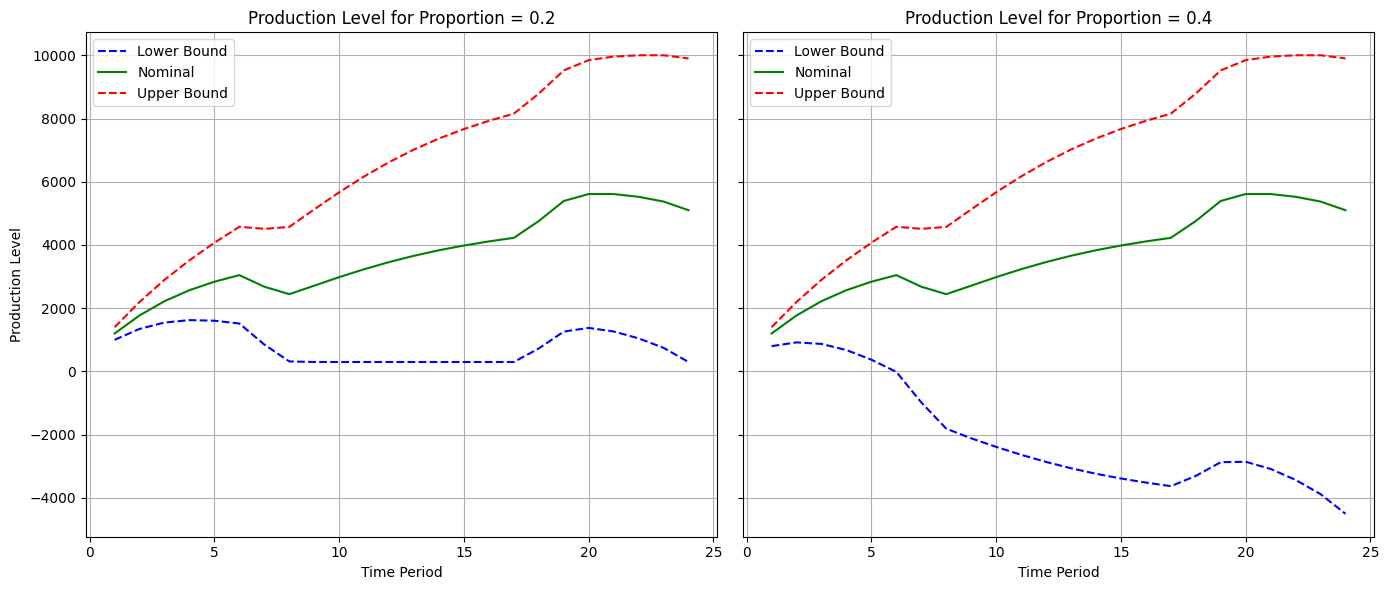

In [ ]:
low_values1 = []
mid_values1 = []
high_values1 = []
for i in range(1, T + 1):
    multvec = np.hstack([np.ones(i), np.zeros(T - i)])
    low = (cp.sum(cp.sum(p, 0)[:i]) - multvec @ rhs_upper1 + V_INITIAL).value
    mid = (cp.sum(cp.sum(p, 0)[:i]) - multvec @ d_star + V_INITIAL).value
    high = (cp.sum(cp.sum(p, 0)[:i]) - multvec @ (-rhs_lower1) + V_INITIAL).value
    
    low_values1.append(low)
    mid_values1.append(mid)
    high_values1.append(high)

# Compute values for the second dataset
low_values2 = []
mid_values2 = []
high_values2 = []
for i in range(1, T + 1):
    multvec = np.hstack([np.ones(i), np.zeros(T - i)])
    low = (cp.sum(cp.sum(p, 0)[:i]) - multvec @ rhs_upper2 + V_INITIAL).value
    mid = (cp.sum(cp.sum(p, 0)[:i]) - multvec @ d_star + V_INITIAL).value
    high = (cp.sum(cp.sum(p, 0)[:i]) - multvec @ (-rhs_lower2) + V_INITIAL).value
    
    low_values2.append(low)
    mid_values2.append(mid)
    high_values2.append(high)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for the first dataset
axs[0].plot(range(1, T + 1), low_values1, label='Lower Bound', color='blue', linestyle='--')
axs[0].plot(range(1, T + 1), mid_values1, label='Nominal', color='green', linestyle='-')
axs[0].plot(range(1, T + 1), high_values1, label='Upper Bound', color='red', linestyle='--')
axs[0].set_xlabel('Time Period')
axs[0].set_ylabel('Production Level')
axs[0].set_title('Production Level for Proportion = 0.2')
axs[0].legend()
axs[0].grid(True)

# Plot for the second dataset
axs[1].plot(range(1, T + 1), low_values2, label='Lower Bound', color='blue', linestyle='--')
axs[1].plot(range(1, T + 1), mid_values2, label='Nominal', color='green', linestyle='-')
axs[1].plot(range(1, T + 1), high_values2, label='Upper Bound', color='red', linestyle='--')
axs[1].set_xlabel('Time Period')
axs[1].set_title('Production Level for Proportion = 0.4')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()